In [7]:
import os
import pandas as pd
import numpy as np
import time
import pickle
import os
import pandas as pd
import numpy as np
import time
import pickle
import glob
import os
import pickle
import time
import uuid
from datetime import datetime
from itertools import product
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

#from lazypredict.Supervised import LazyClassifier as LazyClassifier_
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import sklearn.ensemble as ensemble_models
import shap


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [8]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [9]:
import zipfile
import os

# Define the path to your .zip file
zip_path = 'sessions.pkl.zip'
extraction_path = ''  # The directory to which the .pkl file will be extracted

# Open the .zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract all the contents into the directory
    zip_ref.extractall(extraction_path)


# Define the path to your .zip file
zip_path = 'users.pkl.zip'
extraction_path = ''  # The directory to which the .pkl file will be extracted

# Open the .zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract all the contents into the directory
    zip_ref.extractall(extraction_path)

# Define the path to your .zip file
zip_path = 'purchases.pkl.zip'
extraction_path = ''  # The directory to which the .pkl file will be extracted

# Open the .zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract all the contents into the directory
    zip_ref.extractall(extraction_path)


# Define the path to your .zip file
zip_path = 'model_data.pkl.zip'
extraction_path = ''  # The directory to which the .pkl file will be extracted

# Open the .zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract all the contents into the directory
    zip_ref.extractall(extraction_path)

In [10]:
with open("users.pkl", "rb") as fp:
    users = pickle.load(fp)

with open("sessions.pkl", "rb") as fp:
    sessions = pickle.load(fp)

with open("purchases.pkl", "rb") as fp:
    purchases = pickle.load(fp)

# Data Cleaning

In [11]:
print(users.head())
print(users.shape)

   user_id   join_date       os        country
0   157844  2021-12-05  Android  United States
1   583785  2022-06-25      iOS        Germany
2   152828  2021-12-04      iOS  United States
3   948940  2022-09-19  Android          Spain
4  1141021  2022-12-25  Android        Austria
(6584, 4)


In [12]:
print(sessions.head())
print(sessions.shape)

  user_id          dt  session_id  session_duration_sec  level_completed
0  567638  2022-06-30  1656557867                  3141                9
1  436895  2022-06-30  1656581942                  2419                7
2  443735  2022-06-30  1656548061                  6391                3
3  441407  2022-06-30  1656604859                  1743                4
4  145625  2022-06-30  1656583677                  1265                3
(1699352, 5)


In [13]:
print(purchases.head())
print(purchases.shape)

  user_id          dt  price_usd
0  424859  2022-06-02       5.65
1  360664  2022-06-02       2.33
2  424859  2022-06-02       5.65
3  470675  2022-06-02       2.25
4  522906  2022-06-02       3.51
(236270, 3)


In [14]:
sessions.isna().sum()

user_id                       0
dt                            0
session_id                    0
session_duration_sec          0
level_completed         1398023
dtype: int64

In [15]:
# replacing sessions without level completion (NaNs) with 0 
sessions = sessions.replace(pd.NA, 0)

In [16]:
# <30 sec sessions are not informative
sessions = sessions[sessions.session_duration_sec>30]

In [17]:
users.isna().sum()

user_id      0
join_date    0
os           0
country      0
dtype: int64

In [18]:
purchases.isna().sum()

user_id        0
dt             0
price_usd    109
dtype: int64

In [19]:
purchases.dropna(inplace=True)

In [20]:
purchases[purchases.price_usd <= 0.0]

,user_id,dt,price_usd


## Feature Engineering

In [21]:
# given that our churn horizon is 3 days, we should be able to look 3 days ahead to see whether the user visits
# to do that, we create each day and user unique rows

In [22]:
unique_session_days_per_user = sessions[["user_id", "dt"]].drop_duplicates() # to use later on

In [23]:
# total number of unique days and users
len(unique_session_days_per_user)

574859

In [24]:
daily_session_counts = sessions.groupby(
    ["user_id", "dt"]
).count()[["session_id"]].rename(
    columns = {"session_id": "session_count"}
)


daily_level_completion = sessions.groupby(
    ["user_id", "dt"]
).sum()[["level_completed"]].rename(
    columns = {"level_completed": "level_complete_count"}
)


daily_session_durations = sessions.groupby(
    ["user_id", "dt"]
).sum()[["session_duration_sec"]].rename(
    columns = {"session_duration_sec": "session_duration"}
)

In [25]:
# main dataframe to add other related columns
base = sessions[["user_id", "dt"]].drop_duplicates()

In [26]:
base["pseudo_column"] = 1 # to be able to use join through indexes

In [27]:
# faster join with indexes

base = base.set_index(
    ["user_id", "dt"]
).join(
    daily_session_counts, how="left"
).join(
    daily_level_completion, how="left"
).join(
    daily_session_durations, how="left"
).drop(
    "pseudo_column", 
    1
).reset_index(
)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


In [28]:
base = base.merge(
    users,
    how="left",
    on="user_id"
)

base["days_since_join"] = (base.dt - base.join_date).dt.days
base.drop("join_date", 1, inplace=True)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


In [29]:
# for each user and dt pair, session count, level completion session duration and days since join information are prepared as below
base

,user_id,dt,session_count,level_complete_count,session_duration,os,country,days_since_join
0,567638,2022-06-30,1,9,3141,iOS,United States,12
1,436895,2022-06-30,3,11,4284,iOS,United Kingdom,85
2,443735,2022-06-30,1,3,6391,iOS,United States,81
3,441407,2022-06-30,6,7,4483,iOS,United Kingdom,83
4,145625,2022-06-30,1,3,1265,iOS,United Kingdom,214
...,...,...,...,...,...,...,...,...
574854,635277,2022-08-20,1,0,67,Android,Germany,39
574855,124715,2022-08-20,1,0,35,Android,Bosnia & Herzegovina,287
574856,768569,2022-08-20,1,0,32,Android,Germany,11
574857,123792,2022-08-20,3,0,2099,Android,Germany,288


In [30]:
# for those that have been inactive for somedays, we should cross join all days and should set session count to 0

In [31]:
# to calculate activity we need logs of every day for every user, thus we outer join unique days and users

### Label Creation

In [32]:
unique_days = pd.DataFrame(base["dt"].unique(), columns=["dt"])
unique_users = pd.DataFrame(base["user_id"].unique(), columns=["user_id"])

unique_days["key"] = 1
unique_users["key"] = 1

In [33]:
all_days_and_users = pd.merge(unique_days, unique_users, how="outer", on="key").drop("key", 1)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


In [34]:
base = all_days_and_users.merge(
    base,
    how="left",
    on=["user_id", "dt"]
)

In [35]:
# filling na values on the days when users have been inactive

In [36]:
base.replace(pd.NA, 0, inplace=True)

In [37]:
base.replace(np.nan, 0, inplace=True)

In [38]:
base.isna().sum()

dt                      0
user_id                 0
session_count           0
level_complete_count    0
session_duration        0
os                      0
country                 0
days_since_join         0
dtype: int64

In [39]:
base = base.sort_values(['user_id', "dt"]).reset_index(drop=True)

# to create the label of churning in the next 3 days, the data from the next 3 days are extracted
base['tomorrow_session_count'] = base.groupby(['user_id'])['session_count'].transform(lambda x: x.shift(-1))
base['2days_later_session_count'] = base.groupby(['user_id'])['session_count'].transform(lambda x: x.shift(-2))
base['3days_later_session_count'] = base.groupby(['user_id'])['session_count'].transform(lambda x: x.shift(-3))

base['label'] = np.where(
    base['tomorrow_session_count'] + 
    base['2days_later_session_count'] + 
    base['3days_later_session_count'] > 0.0, 
    0, 
    1
)

base.drop(["tomorrow_session_count", "2days_later_session_count", "3days_later_session_count"], 1, inplace=True)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


## Purchases

In [40]:
daily_purchase_counts = purchases.groupby(
    ["user_id", "dt"]
).count()[["price_usd"]].rename(
    columns = {"price_usd": "purchase_count"}
)

daily_purchase_amounts = purchases.groupby(
    ["user_id", "dt"]
).sum()[["price_usd"]].rename(
    columns = {"price_usd": "purchase_amount"}
)

In [41]:
base["pseudo_column"] = 1

base = base.set_index(
    ["user_id", "dt"]
).join(
    daily_purchase_counts, how="left"
).join(
    daily_purchase_amounts, how="left"
).drop(
    "pseudo_column", 
    1
).reset_index(
)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


In [42]:
base.replace(np.nan, 0, inplace=True)

In [43]:
base

,user_id,dt,session_count,level_complete_count,session_duration,os,country,days_since_join,label,purchase_count,purchase_amount
0,1000053,2022-06-02,0.0,0,0,0,0,0.0,1,0.0,0.0
1,1000053,2022-06-03,0.0,0,0,0,0,0.0,1,0.0,0.0
2,1000053,2022-06-04,0.0,0,0,0,0,0.0,1,0.0,0.0
3,1000053,2022-06-05,0.0,0,0,0,0,0.0,1,0.0,0.0
4,1000053,2022-06-06,0.0,0,0,0,0,0.0,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1346515,999438,2022-12-24,2.0,0,2324,Android,United States,81.0,0,0.0,0.0
1346516,999438,2022-12-25,2.0,0,3391,Android,United States,82.0,0,0.0,0.0
1346517,999438,2022-12-26,2.0,0,1736,Android,United States,83.0,1,0.0,0.0
1346518,999438,2022-12-27,3.0,0,2403,Android,United States,84.0,1,0.0,0.0


In [44]:
purchases_w_country_and_os = purchases.merge(
    users[["user_id", "country", "os"]],
    how="left",
    on="user_id"
).dropna(
)

In [45]:
purchases.isna().sum()

user_id      0
dt           0
price_usd    0
dtype: int64

In [46]:
# there are 125 countries, if we take them into modelling it might create a too sparse data set
# therefore we are looking for a way to reduce the cardinality of the parameter

In [47]:
import matplotlib.pyplot as plt

In [48]:
country_purchase_counts = purchases_w_country_and_os.groupby("country").count()["user_id"].sort_values(ascending=False)

country_purchase_amounts = purchases_w_country_and_os.groupby("country").sum()["price_usd"].sort_values(ascending=False)

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


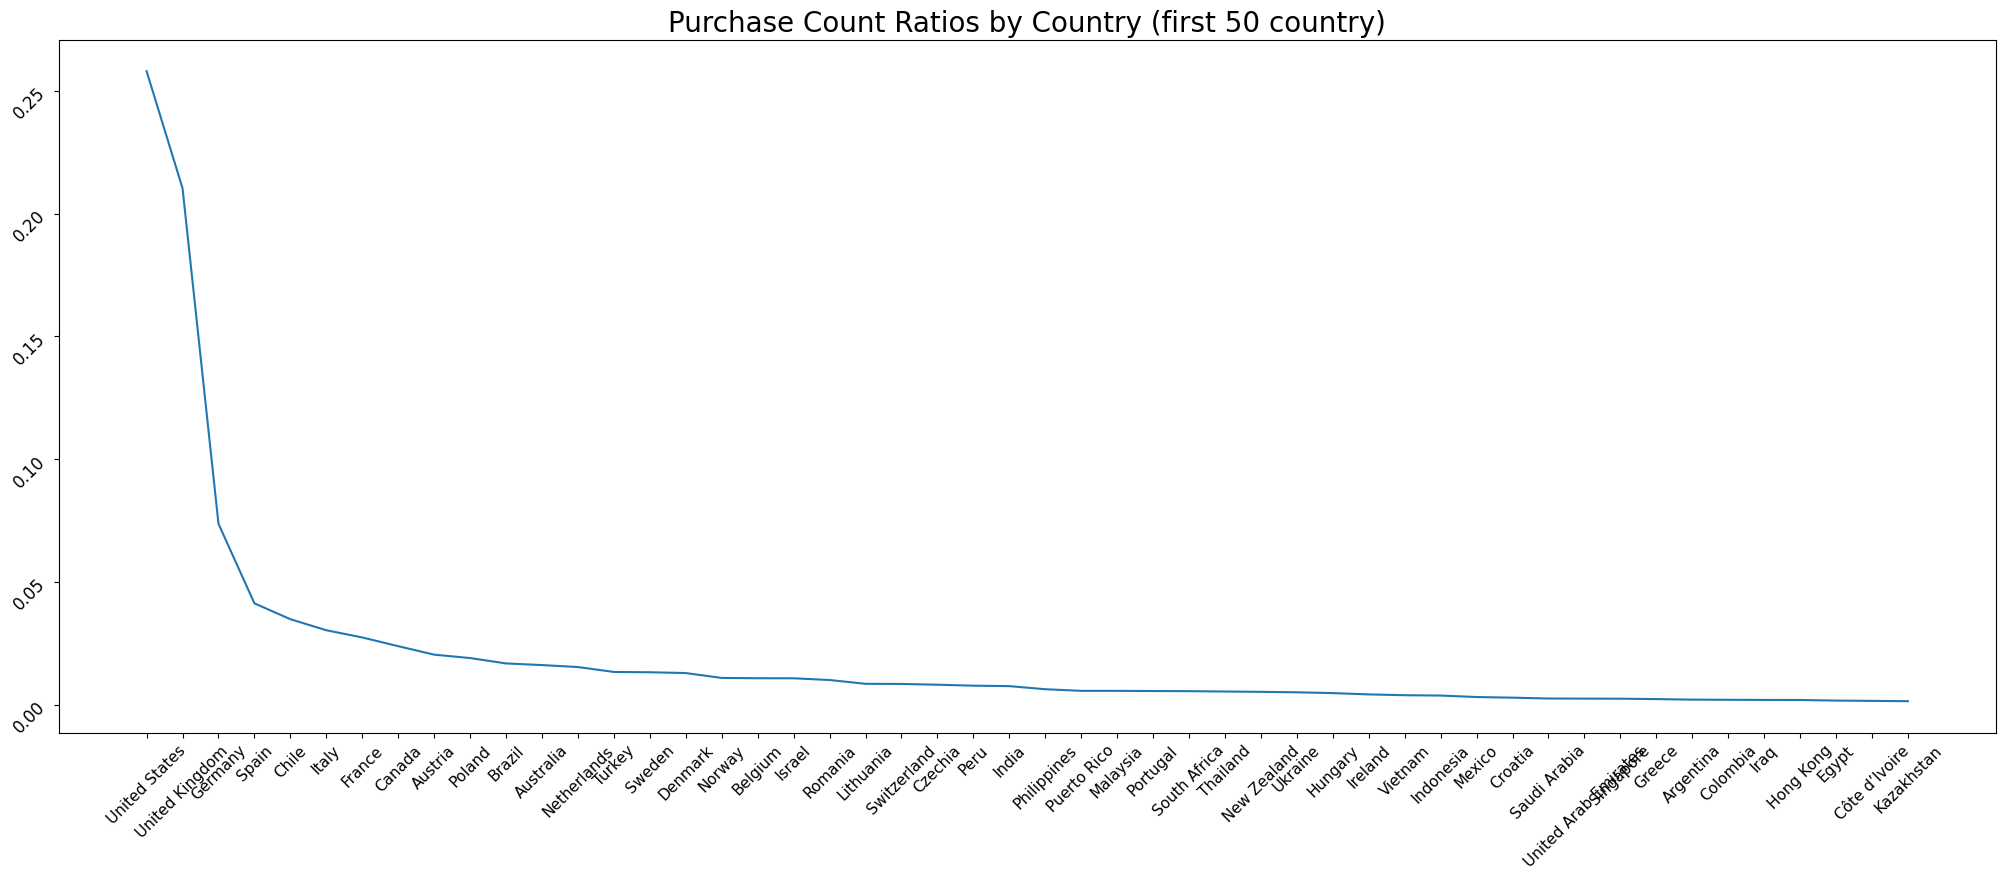

In [49]:
df_to_plot = country_purchase_counts.iloc[:50]
df_to_plot = df_to_plot / df_to_plot.sum()

plt.figure(figsize=(25,9))
plt.plot(df_to_plot)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(rotation=45, fontsize=12)
plt.title("Purchase Count Ratios by Country (first 50 country)", fontsize=20)

plt.show()

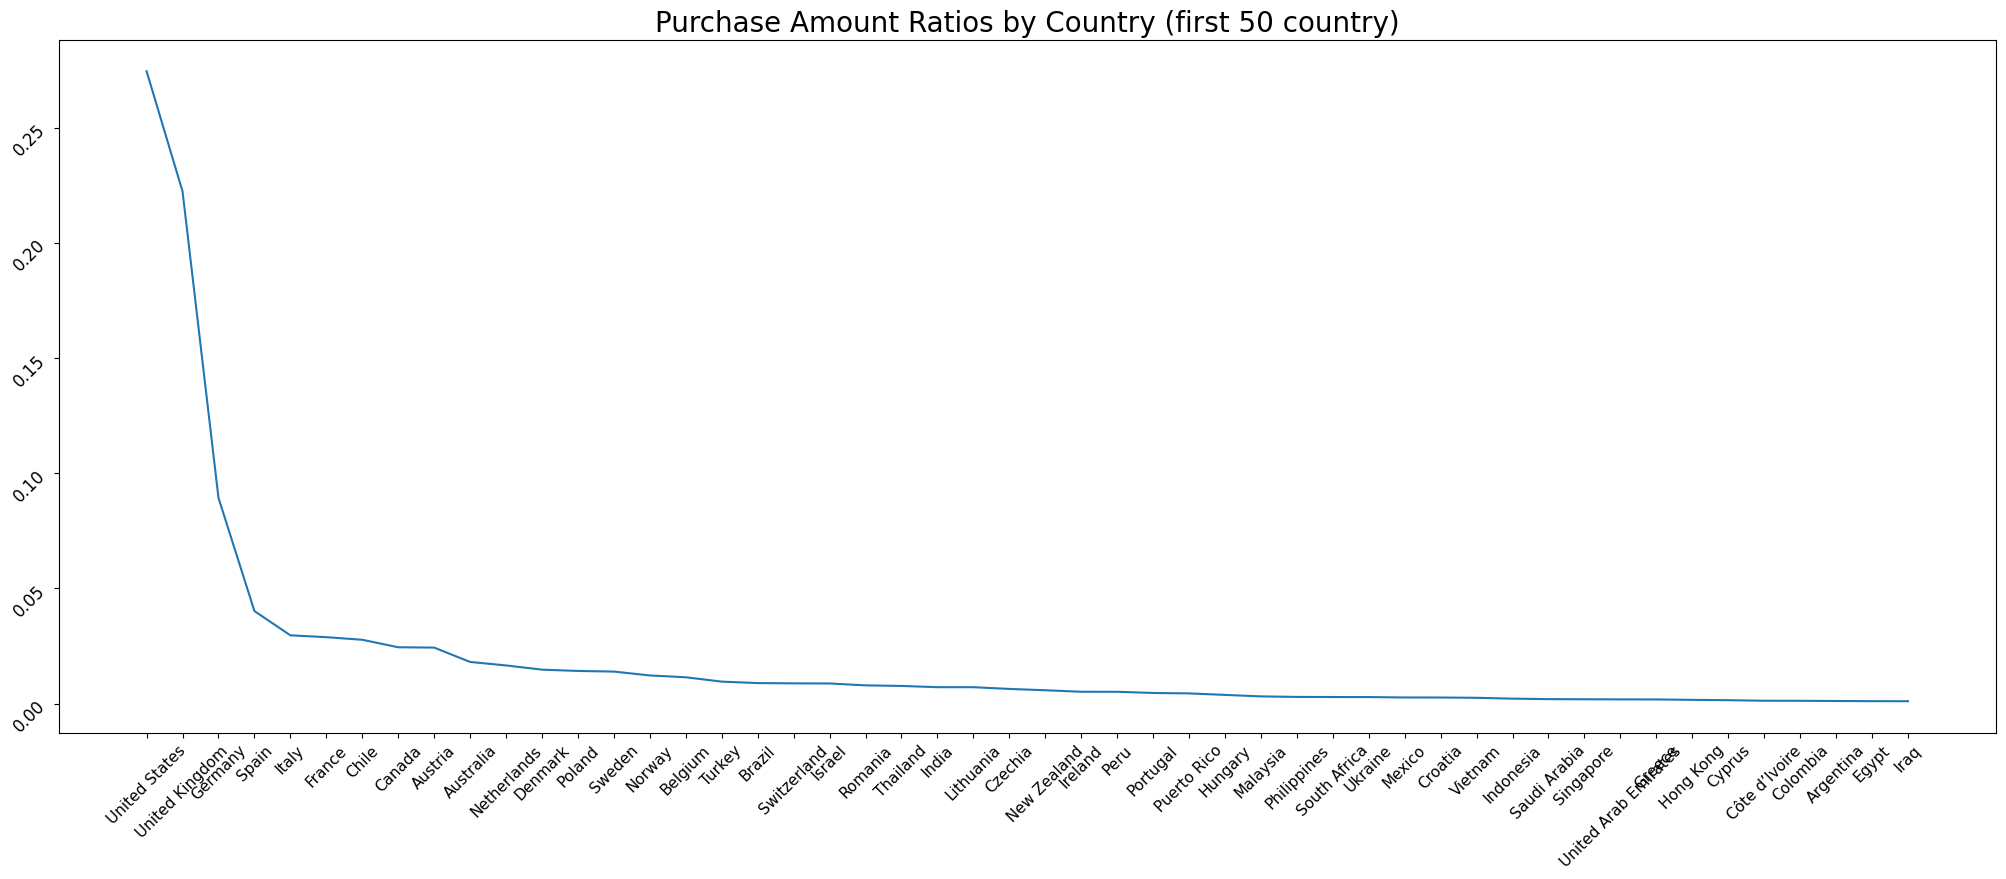

In [50]:
df_to_plot = country_purchase_amounts.iloc[:50]
df_to_plot = df_to_plot / df_to_plot.sum()

plt.figure(figsize=(25,9))
plt.plot(df_to_plot)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(rotation=45, fontsize=12)
plt.title("Purchase Amount Ratios by Country (first 50 country)", fontsize=20)

plt.show()

In [51]:
purchases_w_country_and_os["country_tier"] = np.where(
    purchases_w_country_and_os["country"].isin(["United States", "United Kingdom"]),
    "tier1",
    np.where(
        purchases_w_country_and_os["country"].isin(
            ["Germany", "Spain", "Italy", "France", "Canada", "Austria", "Australia", "Netherlands", "Denmark", "Poland", "Sweden", "Norway", "Belgium"]
        ),
        "tier2",
        "tier3"
    )
)

# Feature Engineering

In [52]:
# overall

In [53]:
feat_total_purchases = purchases.groupby('dt')['price_usd'].count().shift(1).reset_index().rename(columns={'price_usd': '1d_ago_total_purchase_count'})
feat_total_purchases['2d_ago_total_purchase_count'] = purchases.groupby('dt')['price_usd'].count().shift(2).reset_index()["price_usd"]
feat_total_purchases['3d_ago_total_purchase_count'] = purchases.groupby('dt')['price_usd'].count().shift(3).reset_index()["price_usd"]

In [54]:
feat_total_purchases['1d_ago_total_purchase_amount'] = purchases.groupby('dt')['price_usd'].sum().shift(1).reset_index()["price_usd"]
feat_total_purchases['2d_ago_total_purchase_amount'] = purchases.groupby('dt')['price_usd'].sum().shift(2).reset_index()["price_usd"]
feat_total_purchases['3d_ago_total_purchase_amount'] = purchases.groupby('dt')['price_usd'].sum().shift(3).reset_index()["price_usd"]

In [55]:
# country based

In [56]:
feat_total_purchases_per_country = purchases_w_country_and_os.groupby(['dt', 'country_tier'])['price_usd'].count().shift(1).reset_index().rename(columns={'price_usd': '1d_ago_total_purchase_count_per_country'})
feat_total_purchases_per_country['2d_ago_total_purchase_count_per_country'] = purchases_w_country_and_os.groupby(['dt', 'country_tier'])['price_usd'].count().shift(2).reset_index()['price_usd']
feat_total_purchases_per_country['3d_ago_total_purchase_count_per_country'] = purchases_w_country_and_os.groupby(['dt', 'country_tier'])['price_usd'].count().shift(3).reset_index()['price_usd']

In [57]:
feat_total_purchases_per_country["1d_ago_total_purchase_amount_per_country"] = purchases_w_country_and_os.groupby(['dt', 'country_tier'])['price_usd'].sum().shift(1).reset_index()['price_usd']
feat_total_purchases_per_country['2d_ago_total_purchase_amount_per_country'] = purchases_w_country_and_os.groupby(['dt', 'country_tier'])['price_usd'].sum().shift(2).reset_index()['price_usd']
feat_total_purchases_per_country['3d_ago_total_purchase_amount_per_country'] = purchases_w_country_and_os.groupby(['dt', 'country_tier'])['price_usd'].sum().shift(3).reset_index()['price_usd']

In [58]:
feat_total_purchases_per_country_interim = feat_total_purchases_per_country.merge(feat_total_purchases, on='dt')
feat_total_purchases_per_country['1d_ago_total_purchase_count_ratio_per_country'] = feat_total_purchases_per_country_interim['1d_ago_total_purchase_count_per_country']/feat_total_purchases_per_country_interim['1d_ago_total_purchase_count']
feat_total_purchases_per_country['2d_ago_total_purchase_count_ratio_per_country'] = feat_total_purchases_per_country_interim['2d_ago_total_purchase_count_per_country']/feat_total_purchases_per_country_interim['2d_ago_total_purchase_count']
feat_total_purchases_per_country['3d_ago_total_purchase_count_ratio_per_country'] = feat_total_purchases_per_country_interim['3d_ago_total_purchase_count_per_country']/feat_total_purchases_per_country_interim['3d_ago_total_purchase_count']

feat_total_purchases_per_country['1d_ago_total_purchase_amount_ratio_per_country'] = feat_total_purchases_per_country_interim['1d_ago_total_purchase_amount_per_country']/feat_total_purchases_per_country_interim['1d_ago_total_purchase_amount']
feat_total_purchases_per_country['2d_ago_total_purchase_amount_ratio_per_country'] = feat_total_purchases_per_country_interim['2d_ago_total_purchase_amount_per_country']/feat_total_purchases_per_country_interim['2d_ago_total_purchase_amount']
feat_total_purchases_per_country['3d_ago_total_purchase_amount_ratio_per_country'] = feat_total_purchases_per_country_interim['3d_ago_total_purchase_amount_per_country']/feat_total_purchases_per_country_interim['3d_ago_total_purchase_amount']

In [59]:
# os based

In [60]:
feat_total_purchases_per_os = purchases_w_country_and_os.groupby(['dt', 'os'])['price_usd'].count().shift(1).reset_index().rename(columns={'price_usd': '1d_ago_total_purchase_count_per_os'})
feat_total_purchases_per_os['2d_ago_total_purchase_count_per_os'] = purchases_w_country_and_os.groupby(['dt', 'os'])['price_usd'].count().shift(2).reset_index()['price_usd']
feat_total_purchases_per_os['3d_ago_total_purchase_count_per_os'] = purchases_w_country_and_os.groupby(['dt', 'os'])['price_usd'].count().shift(3).reset_index()['price_usd']

In [61]:
# ppu (purchase per user)

In [62]:
feat_purchases_per_user_temp = base[["user_id", "dt"]].merge(
    purchases[['user_id', 'dt', 'price_usd']],
    how="left",
    on=["user_id", "dt"]
).sort_values(
    ["user_id", "dt"]
) # ppu

feat_purchases_per_user = feat_purchases_per_user_temp.groupby(["user_id", "dt"]).count()["price_usd"].reset_index().rename(columns={"price_usd": "purchase_count"})
feat_purchases_per_user["purchase_amount"] = feat_purchases_per_user_temp.groupby(["user_id", "dt"]).sum()["price_usd"].reset_index()["price_usd"]

feat_purchases_per_user['1d_ago_purchase_amount'] = feat_purchases_per_user.groupby(['user_id', 'dt'])['purchase_amount'].sum().shift(1).reset_index()['purchase_amount']
feat_purchases_per_user['2d_ago_purchase_amount'] = feat_purchases_per_user.groupby(['user_id', 'dt'])['purchase_amount'].sum().shift(2).reset_index()['purchase_amount']
feat_purchases_per_user['3d_ago_purchase_amount'] = feat_purchases_per_user.groupby(['user_id', 'dt'])['purchase_amount'].sum().shift(3).reset_index()['purchase_amount']

feat_purchases_per_user['1d_ago_purchase_count'] = feat_purchases_per_user.groupby(['user_id', 'dt'])['purchase_count'].count().shift(1).reset_index()['purchase_count']
feat_purchases_per_user['2d_ago_purchase_count'] = feat_purchases_per_user.groupby(['user_id', 'dt'])['purchase_count'].count().shift(2).reset_index()['purchase_count']
feat_purchases_per_user['3d_ago_purchase_count'] = feat_purchases_per_user.groupby(['user_id', 'dt'])['purchase_count'].count().shift(3).reset_index()['purchase_count']

# cumulative sum of amounts
feat_purchases_per_user['l2d_ago_purchase_amount'] = feat_purchases_per_user.groupby(['user_id'])['purchase_amount'].rolling(2, min_periods = 1).sum().shift(1).reset_index()['purchase_amount']
feat_purchases_per_user['l3d_ago_purchase_amount'] = feat_purchases_per_user.groupby(['user_id'])['purchase_amount'].rolling(3, min_periods = 1).sum().shift(1).reset_index()['purchase_amount']
feat_purchases_per_user['l5d_ago_purchase_amount'] = feat_purchases_per_user.groupby(['user_id'])['purchase_amount'].rolling(5, min_periods = 1).sum().shift(1).reset_index()['purchase_amount']
feat_purchases_per_user['l7d_ago_purchase_amount'] = feat_purchases_per_user.groupby(['user_id'])['purchase_amount'].rolling(7, min_periods = 1).sum().shift(1).reset_index()['purchase_amount']
feat_purchases_per_user['l9d_ago_purchase_amount'] = feat_purchases_per_user.groupby(['user_id'])['purchase_amount'].rolling(9, min_periods = 1).sum().shift(1).reset_index()['purchase_amount']

# cumulative sum of counts
feat_purchases_per_user['l2d_ago_purchase_count'] = feat_purchases_per_user.groupby(['user_id'])['purchase_count'].rolling(2, min_periods = 1).count().shift(1).reset_index()['purchase_count']
feat_purchases_per_user['l3d_ago_purchase_count'] = feat_purchases_per_user.groupby(['user_id'])['purchase_count'].rolling(3, min_periods = 1).count().shift(1).reset_index()['purchase_count']
feat_purchases_per_user['l5d_ago_purchase_count'] = feat_purchases_per_user.groupby(['user_id'])['purchase_count'].rolling(5, min_periods = 1).count().shift(1).reset_index()['purchase_count']
feat_purchases_per_user['l7d_ago_purchase_count'] = feat_purchases_per_user.groupby(['user_id'])['purchase_count'].rolling(7, min_periods = 1).count().shift(1).reset_index()['purchase_count']
feat_purchases_per_user['l9d_ago_purchase_count'] = feat_purchases_per_user.groupby(['user_id'])['purchase_count'].rolling(9, min_periods = 1).count().shift(1).reset_index()['purchase_count']



In [63]:
# session count per user

In [64]:
feat_session_counts_per_user = base[["user_id", "dt", "session_count"]].sort_values(["user_id", "dt"])

# last days session count
feat_session_counts_per_user['1d_ago_session_counts'] = feat_session_counts_per_user.groupby(['user_id', 'dt'])['session_count'].sum().shift(1).reset_index()['session_count']
feat_session_counts_per_user['2d_ago_session_counts'] = feat_session_counts_per_user.groupby(['user_id', 'dt'])['session_count'].sum().shift(2).reset_index()['session_count']
feat_session_counts_per_user['3d_ago_session_counts'] = feat_session_counts_per_user.groupby(['user_id', 'dt'])['session_count'].sum().shift(3).reset_index()['session_count']

# cumulative sum of session counts
feat_session_counts_per_user['l2d_ago_session_counts'] = feat_session_counts_per_user.groupby(['user_id'])['session_count'].rolling(2, min_periods = 1).sum().shift(1).reset_index()['session_count']
feat_session_counts_per_user['l3d_ago_session_counts'] = feat_session_counts_per_user.groupby(['user_id'])['session_count'].rolling(3, min_periods = 1).sum().shift(1).reset_index()['session_count']
feat_session_counts_per_user['l5d_ago_session_counts'] = feat_session_counts_per_user.groupby(['user_id'])['session_count'].rolling(5, min_periods = 1).sum().shift(1).reset_index()['session_count']
feat_session_counts_per_user['l7d_ago_session_counts'] = feat_session_counts_per_user.groupby(['user_id'])['session_count'].rolling(7, min_periods = 1).sum().shift(1).reset_index()['session_count']
feat_session_counts_per_user['l9d_ago_session_counts'] = feat_session_counts_per_user.groupby(['user_id'])['session_count'].rolling(9, min_periods = 1).sum().shift(1).reset_index()['session_count']

feat_session_counts_per_user.drop(
    "session_count",
    1,
    inplace=True
)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


In [65]:
# session duration per user

In [66]:
feat_session_durations_per_user = base[["user_id", "dt", "session_duration"]].sort_values(["user_id", "dt"])

# last days session durations
feat_session_durations_per_user['1d_ago_session_durations'] = feat_session_durations_per_user.groupby(['user_id', 'dt'])['session_duration'].sum().shift(1).reset_index()['session_duration']
feat_session_durations_per_user['2d_ago_session_durations'] = feat_session_durations_per_user.groupby(['user_id', 'dt'])['session_duration'].sum().shift(2).reset_index()['session_duration']
feat_session_durations_per_user['3d_ago_session_durations'] = feat_session_durations_per_user.groupby(['user_id', 'dt'])['session_duration'].sum().shift(3).reset_index()['session_duration']

# cumulative sum of session durations
feat_session_durations_per_user['l2d_ago_session_durations'] = feat_session_durations_per_user.groupby(['user_id'])['session_duration'].rolling(2, min_periods = 1).sum().shift(1).reset_index()['session_duration']
feat_session_durations_per_user['l3d_ago_session_durations'] = feat_session_durations_per_user.groupby(['user_id'])['session_duration'].rolling(3, min_periods = 1).sum().shift(1).reset_index()['session_duration']
feat_session_durations_per_user['l5d_ago_session_durations'] = feat_session_durations_per_user.groupby(['user_id'])['session_duration'].rolling(5, min_periods = 1).sum().shift(1).reset_index()['session_duration']
feat_session_durations_per_user['l7d_ago_session_durations'] = feat_session_durations_per_user.groupby(['user_id'])['session_duration'].rolling(7, min_periods = 1).sum().shift(1).reset_index()['session_duration']
feat_session_durations_per_user['l9d_ago_session_durations'] = feat_session_durations_per_user.groupby(['user_id'])['session_duration'].rolling(9, min_periods = 1).sum().shift(1).reset_index()['session_duration']

feat_session_durations_per_user.drop(
    "session_duration",
    1,
    inplace=True
)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


In [67]:
#level complete counts

In [68]:
feat_level_complete_counts_per_user = base[["user_id", "dt", "level_complete_count"]].sort_values(["user_id", "dt"])

# last days level complete counts
feat_level_complete_counts_per_user['1d_ago_level_complete_count'] = feat_level_complete_counts_per_user.groupby(['user_id', 'dt'])['level_complete_count'].sum().shift(1).reset_index()['level_complete_count']
feat_level_complete_counts_per_user['2d_ago_level_complete_count'] = feat_level_complete_counts_per_user.groupby(['user_id', 'dt'])['level_complete_count'].sum().shift(2).reset_index()['level_complete_count']
feat_level_complete_counts_per_user['3d_ago_level_complete_count'] = feat_level_complete_counts_per_user.groupby(['user_id', 'dt'])['level_complete_count'].sum().shift(3).reset_index()['level_complete_count']

# cumulative sum of level complete counts
feat_level_complete_counts_per_user['l2d_ago_level_complete_count'] = feat_level_complete_counts_per_user.groupby(['user_id'])['level_complete_count'].rolling(2, min_periods = 1).sum().shift(1).reset_index()['level_complete_count']
feat_level_complete_counts_per_user['l3d_ago_level_complete_count'] = feat_level_complete_counts_per_user.groupby(['user_id'])['level_complete_count'].rolling(3, min_periods = 1).sum().shift(1).reset_index()['level_complete_count']
feat_level_complete_counts_per_user['l5d_ago_level_complete_count'] = feat_level_complete_counts_per_user.groupby(['user_id'])['level_complete_count'].rolling(5, min_periods = 1).sum().shift(1).reset_index()['level_complete_count']
feat_level_complete_counts_per_user['l7d_ago_level_complete_count'] = feat_level_complete_counts_per_user.groupby(['user_id'])['level_complete_count'].rolling(7, min_periods = 1).sum().shift(1).reset_index()['level_complete_count']
feat_level_complete_counts_per_user['l9d_ago_level_complete_count'] = feat_level_complete_counts_per_user.groupby(['user_id'])['level_complete_count'].rolling(9, min_periods = 1).sum().shift(1).reset_index()['level_complete_count']

feat_level_complete_counts_per_user.drop(
    "level_complete_count",
    1,
    inplace=True
)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


## feature datasets

- feat_total_purchases
- feat_total_purchases_per_country
- feat_total_purchases_per_os
- feat_purchases_per_user
- feat_session_counts_per_user
- feat_session_durations_per_user
- feat_level_complete_counts_per_user

In [69]:
base["country_tier"] = np.where(
    base["country"].isin(["United States", "United Kingdom"]),
    "tier1",
    np.where(
        base["country"].isin(
            ["Germany", "Spain", "Italy", "France", "Canada", "Austria", "Australia", "Netherlands", "Denmark", "Poland", "Sweden", "Norway", "Belgium"]
        ),
        "tier2",
        "tier3"
    )
)

base.drop("country", 1, inplace=True)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


In [70]:
base

,user_id,dt,session_count,level_complete_count,session_duration,os,days_since_join,label,purchase_count,purchase_amount,country_tier
0,1000053,2022-06-02,0.0,0,0,0,0.0,1,0.0,0.0,tier3
1,1000053,2022-06-03,0.0,0,0,0,0.0,1,0.0,0.0,tier3
2,1000053,2022-06-04,0.0,0,0,0,0.0,1,0.0,0.0,tier3
3,1000053,2022-06-05,0.0,0,0,0,0.0,1,0.0,0.0,tier3
4,1000053,2022-06-06,0.0,0,0,0,0.0,1,0.0,0.0,tier3
...,...,...,...,...,...,...,...,...,...,...,...
1346515,999438,2022-12-24,2.0,0,2324,Android,81.0,0,0.0,0.0,tier1
1346516,999438,2022-12-25,2.0,0,3391,Android,82.0,0,0.0,0.0,tier1
1346517,999438,2022-12-26,2.0,0,1736,Android,83.0,1,0.0,0.0,tier1
1346518,999438,2022-12-27,3.0,0,2403,Android,84.0,1,0.0,0.0,tier1


In [71]:
data = base\
.merge(
    
    feat_total_purchases,
    how="left",
    on="dt"
    
).merge(
    
    feat_total_purchases_per_country,
    how="left",
    on=["dt", "country_tier"]
    
).merge(
    
    feat_total_purchases_per_os,
    how="left",
    on=["dt", "os"]
    
).merge(
    
    feat_purchases_per_user,
    how="left",
    on=["dt", "user_id"]
    
).merge(
    
    feat_session_counts_per_user,
    how="left",
    on=["dt", "user_id"]
    
).merge(
    
    feat_session_durations_per_user,
    how="left",
    on=["dt", "user_id"]
    
).merge(
    
    feat_level_complete_counts_per_user,
    how="left",
    on=["dt", "user_id"]
    
)

In [72]:
data

,user_id,dt,session_count,level_complete_count,session_duration,os,days_since_join,label,purchase_count_x,purchase_amount_x,country_tier,1d_ago_total_purchase_count,2d_ago_total_purchase_count,3d_ago_total_purchase_count,1d_ago_total_purchase_amount,2d_ago_total_purchase_amount,3d_ago_total_purchase_amount,1d_ago_total_purchase_count_per_country,2d_ago_total_purchase_count_per_country,3d_ago_total_purchase_count_per_country,1d_ago_total_purchase_amount_per_country,2d_ago_total_purchase_amount_per_country,3d_ago_total_purchase_amount_per_country,1d_ago_total_purchase_count_ratio_per_country,2d_ago_total_purchase_count_ratio_per_country,3d_ago_total_purchase_count_ratio_per_country,1d_ago_total_purchase_amount_ratio_per_country,2d_ago_total_purchase_amount_ratio_per_country,3d_ago_total_purchase_amount_ratio_per_country,1d_ago_total_purchase_count_per_os,2d_ago_total_purchase_count_per_os,3d_ago_total_purchase_count_per_os,purchase_count_y,purchase_amount_y,1d_ago_purchase_amount,2d_ago_purchase_amount,3d_ago_purchase_amount,1d_ago_purchase_count,2d_ago_purchase_count,3d_ago_purchase_count,l2d_ago_purchase_amount,l3d_ago_purchase_amount,l5d_ago_purchase_amount,l7d_ago_purchase_amount,l9d_ago_purchase_amount,l2d_ago_purchase_count,l3d_ago_purchase_count,l5d_ago_purchase_count,l7d_ago_purchase_count,l9d_ago_purchase_count,1d_ago_session_counts,2d_ago_session_counts,3d_ago_session_counts,l2d_ago_session_counts,l3d_ago_session_counts,l5d_ago_session_counts,l7d_ago_session_counts,l9d_ago_session_counts,1d_ago_session_durations,2d_ago_session_durations,3d_ago_session_durations,l2d_ago_session_durations,l3d_ago_session_durations,l5d_ago_session_durations,l7d_ago_session_durations,l9d_ago_session_durations,1d_ago_level_complete_count,2d_ago_level_complete_count,3d_ago_level_complete_count,l2d_ago_level_complete_count,l3d_ago_level_complete_count,l5d_ago_level_complete_count,l7d_ago_level_complete_count,l9d_ago_level_complete_count
0,1000053,2022-06-02,0.0,0,0,0,0.0,1,0.0,0.0,tier3,NaN,NaN,NaN,NaN,NaN,NaN,66.0,350.0,NaN,330.44,1873.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN
1,1000053,2022-06-03,0.0,0,0,0,0.0,1,0.0,0.0,tier3,718.0,NaN,NaN,3298.67,NaN,NaN,77.0,353.0,94.0,406.75,1901.06,384.78,0.107242,NaN,NaN,0.123307,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,0.0,0.0,0.0,0.0,0.00,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,<NA>,<NA>,0.0,0.0,0.0,0.0,0.0,0,<NA>,<NA>,0.0,0.0,0.0,0.0,0.0
2,1000053,2022-06-04,0.0,0,0,0,0.0,1,0.0,0.0,tier3,736.0,718.0,NaN,3473.90,3298.67,NaN,61.0,359.0,72.0,352.72,1977.53,316.98,0.082880,0.500000,NaN,0.101534,0.599493,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,NaN,1.0,1.0,NaN,0.0,0.0,0.0,0.0,0.00,2.0,2.0,2.0,2.0,2.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0,0,<NA>,0.0,0.0,0.0,0.0,0.0,0,0,<NA>,0.0,0.0,0.0,0.0,0.0
3,1000053,2022-06-05,0.0,0,0,0,0.0,1,0.0,0.0,tier3,723.0,736.0,718.0,3403.21,3473.90,3298.67,66.0,296.0,76.0,270.87,1559.69,236.27,0.091286,0.402174,0.105850,0.079593,0.448974,0.071626,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.00,2.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0
4,1000053,2022-06-06,0.0,0,0,0,0.0,1,0.0,0.0,tier3,686.0,723.0,736.0,2946.03,3403.21,3473.90,59.0,307.0,82.0,277.11,1677.28,256.91,0.086006,0.424620,0.111413,0.094062,0.492852,0.073954,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.00,2.0,3.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346515,999438,2022-12-24,2.0,0,2324,Android,81.0,

In [73]:
# reducing the number of rows from 1346520 rows(dataset with all day-user possibilities) 
# to 574859 rows (only with session days per user)

data_to_model = unique_session_days_per_user.merge(
    data,
    how="left",
    on=["user_id", "dt"]
)

In [74]:
data_to_model.isna().sum()

user_id                                              0
dt                                                   0
session_count                                        0
level_complete_count                                 0
session_duration                                     0
os                                                   0
days_since_join                                      0
label                                                0
purchase_count_x                                     0
purchase_amount_x                                    0
country_tier                                         0
1d_ago_total_purchase_count                       1693
2d_ago_total_purchase_count                       3359
3d_ago_total_purchase_count                       5060
1d_ago_total_purchase_amount                      1693
2d_ago_total_purchase_amount                      3359
3d_ago_total_purchase_amount                      5060
1d_ago_total_purchase_count_per_country           1123
2d_ago_tot

In [75]:
data_to_model = data_to_model.drop(["user_id", "dt"], 1)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


# Modelling

In [76]:
with open("model_data.pkl", "rb") as fp:
    model_data = pickle.load(fp)

In [77]:

class Classifier:

    def __init__(
            self,
            verbose=0,
            ignore_warnings=True
    ):
        self.index = 0
        self.model_data = None
        self.lazy_clf = None
        self.try_multiple_models = None
        self.undersample_multiple_models = None
        self.path = os.getcwd()
        self.verbose = verbose
        self.random_state = 42
        self.ignore_warnings = ignore_warnings
        self.models = {}
        self.target = "label"
        self.validation_size = 0.15
        self.test_size = 0.15
        self.undersample_fracs=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1]
        self.custom_metric = recall_score  # function
        self.path_to_creds = None
        self.query = None

    def shap_feature_importance(self):
        # Assuming you have already identified the best model
        # and it is stored in self.best_model after calling get_best_model()
        best_model = self.best_model
        
        # Check if the best_model is a GridSearchCV or similar
        if hasattr(best_model, 'best_estimator_'):
            best_model = best_model.best_estimator_
            
        # We assume self.X_test and self.y_test have been set during preprocessing
        X_test = self.X_test
        y_test = self.y_test

        # Create the SHAP explainer using the best model
        explainer = shap.Explainer(best_model, X_test)

        # Calculate the SHAP values for the test set
        shap_values = explainer(X_test)

        # Plot the SHAP values for the test set
        shap.summary_plot(shap_values, X_test)


    def preprocess_model_data(self):
        # preprocess your data in your way
        data = self.model_data.copy()

        if data.isna().sum().sum() > 0:
            print(f"Null values in the data :\n"
                  f"{self.model_data[self.model_data.columns[self.model_data.isnull().any()].tolist()].isna().mean()}")
            data = data.dropna()
            
        if "user_id" in data.columns:
            data = data.drop("user_id", 1)

        X = data.drop([self.target], 1)
        y = data[self.target]

        numerical_features = []
        categorical_features = []
        for c in X.columns:
            col_type = X[c].dtype
            if col_type == 'object' or col_type.name == 'category':
                categorical_features.append(c)
                X[c] = X[c].astype('category')
            else:
                numerical_features.append(c)
                X[c] = X[c].astype(float)

        for cat_col in categorical_features:
            X = pd.concat([X.drop(cat_col, 1), pd.get_dummies(X[cat_col])], 1)

        y = y.astype("int32")

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=self.test_size,
                                                                                random_state=self.random_state)
        self.X_learn, self.X_val, self.y_learn, self.y_val = train_test_split(self.X_train, self.y_train,
                                                                              test_size=self.validation_size,
                                                                              random_state=self.random_state)

        return

    def create_folder(self):

        if not os.path.exists(self.model_path):
            print("Creating a new folder...")
            os.makedirs(self.model_path)

    def get_last_parameter_set_used(self):

        files = glob.glob(self.model_path + "/*.pkl")

        if files == []:
            print("No parameter set has been used yet.")

        indices = [f.split("/")[-1][:10] for f in files]
        indices = [int(i.split("_")[0]) for i in indices if "_" in i]

        last_pickle_index = max(indices)

        return last_pickle_index

    def get_used_params(self):

        files = glob.glob(self.model_path + "/*.pkl")

        if files == []:
            print("No parameter set has been used yet.")
            return []

        params_used_so_far = []
        for pickle_path in files:
            with open(pickle_path, "rb") as f:
                pickle_ = pickle.load(f)

            params_used_so_far.append(pickle_["classifier"].best_params_)

        return params_used_so_far

    @staticmethod
    def makeGrid(parameters_dict):

        keys = parameters_dict.keys()
        combinations = product(*parameters_dict.values())
        param_combinations = [dict(zip(keys, cc)) for cc in combinations]

        return param_combinations

    @staticmethod
    def unlist_best_param(param=None):

        param_copy = param.copy()
        for k, v in param_copy.items():
            param_copy[k] = v[0]

        return param_copy

    def save_model(self, info_to_save):

        with open(f'{self.model_path}/{self.index}_{datetime.now().strftime("%d%m%Y_%H%M")}.pkl', 'wb') as fp:
            pickle.dump(info_to_save, fp)
        print(
            f'model best estimator saved into : {self.model_path}/{self.index}_{datetime.now().strftime("%d%m%Y_%H%M")}.pkl')

        return

    def undersample_data(self, frac=0.3):
        train = pd.concat([self.X_train, self.y_train], 1)
        return train[train[self.target] == 1].append(train[train[self.target] == 0].sample(frac=frac))

    @staticmethod
    def to_labels(pos_probs, threshold):
        return (pos_probs >= threshold).astype('int')

    def choose_threshold(self, target, pred, start=0.05, finish=0.95, increase=0.01, best='F1', plot=False):

        from numpy import arange

        thresholds = arange(start, finish, increase)

        f1_scores = [f1_score(target, self.to_labels(pred, t)) for t in thresholds]
        recall_scores = [recall_score(target, self.to_labels(pred, t)) for t in thresholds]
        precision_scores = [precision_score(target, self.to_labels(pred, t)) for t in thresholds]

        results = pd.DataFrame(
            list(zip(list(thresholds), f1_scores, recall_scores, precision_scores)),
            columns=['threshold', 'F1', 'recall', 'precision']
        )

        best = results[results[best] == np.max(results[best])]

        if plot:
            plt.figure(figsize=(10, 6))
            plt.plot(results['threshold'], results[['recall', 'precision', 'F1']])
            plt.legend(['recall', 'precision', 'F1'])
            plt.axvline(x=best['threshold'].values[0], ls='-.', color='crimson')
            plt.ylabel('Scores')
            plt.xlabel('Thresholds')
            plt.title('Threshold vs Metric Scores')
            plt.show()

        return results

    def choose_base_learner(self, classifier_names, save=False,
                            scoring=None):

        undersampling_performance = pd.DataFrame()

        for undersample_frac in self.undersample_fracs:
            print(f'\nEliminating {int((1 - undersample_frac) * 100)}% of the training data with label 1...')

            train_undersampled = self.undersample_data(frac=undersample_frac)
            X_train_undersampled = train_undersampled.drop(self.target, 1)
            y_train_undersampled = train_undersampled[[self.target]]

            if scoring is None:
                scoring = "f1"
            
            classes_weights = class_weight.compute_sample_weight(
                    class_weight='balanced',
                    y=y_train_undersampled[self.target]
                )

            for classifier_name in classifier_names:
                start = time.time()
                
                linear=False
                try:
                    import sklearn.ensemble as ensemble_models
                    import sklearn.linear_model as linear_models
                    try:
                        classifier = getattr(ensemble_models, classifier_name)()
                    except:
                        try:
                            classifier = getattr(linear_models, classifier_name)(class_weight="balanced")
                    
                            classifier = make_pipeline(
                                RobustScaler(
                                    with_scaling=True,
                                    quantile_range=(0.01, 0.99)
                                ), 
                                classifier
                            )
                            linear=True
                        except Exception as e:
                            
                            try:
                                import lightgbm as lgb
                                classifier = getattr(lgb, classifier_name)()
                            
                            except Exception as e:
                                import xgboost as xgb
                                classifier = getattr(xgb, classifier_name)()
                except Exception as e:
                    try:
                        import lightgbm as lgb
                        classifier = getattr(lgb, classifier_name)()
                    except Exception as e:
                        import xgboost as xgb
                        classifier = getattr(xgb, classifier_name)()

                print(f'\n{classifier_name} fitting the data...')

                csl = GridSearchCV(estimator=classifier, param_grid={}, scoring="f1", cv=5, return_train_score=True)
                if not linear:
                    csl.fit(X_train_undersampled, y_train_undersampled[self.target],
                            sample_weight=classes_weights)  # sample_weight=classes_weights)
                else:
                    csl.fit(X_train_undersampled, y_train_undersampled[self.target])  
                        
                y_probs = csl.predict_proba(self.X_test)[:, 1]

                metric_results = self.choose_threshold(self.y_test, y_probs, plot=False)
                metric_results["model_name"] = classifier_name
                metric_results["undersample_frac"] = undersample_frac
                metric_results["time_seconds"] = round(time.time() - start, 2)

                undersampling_performance = undersampling_performance.append(metric_results)

            self.undersampling_performance = undersampling_performance

        if save:
            base_learner_model_folder = f"{self.path}/base_learner_results_{datetime.now().strftime('%d%m%Y_%H%M')}"
            os.makedirs(base_learner_model_folder)
            with open(f'{base_learner_model_folder}/base_learner_model_performances.pkl', 'wb') as fp:
                pickle.dump(undersampling_performance, fp)
            print(f'model base learners saved into : {base_learner_model_folder}/base_learner_model_performances.pkl')

        return undersampling_performance.sort_values("F1", ascending=False)

    def classify(self, classifier_name=None, classifier=None, scoring=None, undersample_frac=None):

        if classifier is not None:
            classifier_name = type(classifier).__name__

        self.model_path = self.path + "/" + classifier_name

        if classifier is None:
            #classifier = [m[1] for m in self.lazy_clf.classifiers if m[0] == classifier_name][0]()
            try:
                import sklearn.ensemble as ensemble_models
                classifier = getattr(ensemble_models, classifier_name)()
            except Exception as e:
                print(e)
                try:
                    import lightgbm as lgb
                    classifier = getattr(lgb, classifier_name)()
                except Exception as e:
                    print(e)
                    import xgboost as xgb
                    classifier = getattr(xgb, classifier_name)()

        params_to_go = self.makeGrid(self.parameters)

        try:
            params_used_so_far = self.get_used_params()
        except Exception as e:
            print(e)
            pass

        if scoring is None:
            scoring = "f1"
        if undersample_frac is not None and undersample_frac <= 1:
            train_undersampled = self.undersample_data(frac=undersample_frac)
            X_train_undersampled = train_undersampled.drop(self.target, 1)
            y_train_undersampled = train_undersampled[self.target]

        for param in params_to_go:
            try:
                self.index = max(self.index, self.get_last_parameter_set_used())
                if param in params_used_so_far:
                    continue
            except Exception as e:
                print(e)
                pass

            print(f"\n\n*********** Performing grid search for parameter set {self.index + 1} ***********")
            print("parameters : \n", param)

            param = {k: [v] for k, v in param.items()}

            classes_weights = class_weight.compute_sample_weight(
                class_weight='balanced',
                y=y_train_undersampled
            )

            grid_search = GridSearchCV(classifier, param_grid=param, scoring=scoring, cv=5, return_train_score=True)
            print("\nFitting model...\n")
            t0 = time.time()
            grid_search.fit(
                X_train_undersampled,
                y_train_undersampled,
                sample_weight=classes_weights
            )
            print("Model train completed in %0.3fs" % (time.time() - t0))
            y_preds_test = grid_search.predict_proba(self.X_test)[:, 1]

            threshold_results = self.choose_threshold(self.y_test, y_preds_test)
            threshold_results["data"] = "test"
            print(grid_search.scorer_)
            print("Validation set f1 (threshold 0.5): ", grid_search.best_score_)
            print("Test set f1 (threshold 0.5): ", f1_score(self.y_test, grid_search.predict(self.X_test)))
            self.index += 1
            self.create_folder()
            self.save_model(
                info_to_save={
                    "classifier": grid_search,
                    "feature_names": list(self.X_train.columns),
                    "threshold_results": threshold_results,
                    "index": self.index,
                    "uuid": uuid.uuid4().hex
                }
            )

        print("Modelling ended!")

        return

    def get_best_model(self, metric=None, prioritize_recall=False, save=False, save_all_thresholds=True):

        best_score = 0
        best_model = None
        all_models_thresholds = pd.DataFrame()

        for estimator in glob.glob(f"{self.model_path}/*.pkl"):
            with open(estimator, 'rb') as fp:
                estimator_result = pickle.load(fp)

            if metric is not None:
                # to use a custom metric instead of standard ones such as F1:
                if prioritize_recall:
                    estimator_result["threshold_results"]["F1_modified"] = \
                        (2 * estimator_result["threshold_results"]["precision"] * estimator_result["threshold_results"]["recall"]) / \
                        (estimator_result["threshold_results"]["precision"] + estimator_result["threshold_results"]["recall"] * 1.2)

                    F1_modified = estimator_result["threshold_results"].sort_values("F1_modified", ascending=False).iloc[0]["F1_modified"]

                    if F1_modified > best_score:
                        best_score = F1_modified
                        best_model = estimator_result["classifier"]
                        best_model_results = estimator_result["threshold_results"].sort_values("F1_modified", ascending=False).iloc[0]
                else:
                    F1 = estimator_result["threshold_results"].sort_values("F1", ascending=False).iloc[0]["F1"]

                    if F1 > best_score:
                        best_score = F1
                        best_model = estimator_result["classifier"]
                        best_model_results = estimator_result["threshold_results"].sort_values("F1", ascending=False)
            else:
                temp = estimator_result["threshold_results"]
                temp["classifier"] = type(estimator_result["classifier"].best_estimator_).__name__
                temp["index"] = estimator_result["index"]
                temp["uuid"] = estimator_result["uuid"]
                all_models_thresholds = all_models_thresholds.append(temp)

        if save:
            if metric is not None:
                best_model_folder = f"{self.path}/best_model_{datetime.now().strftime('%d%m%Y_%H%M')}"
                os.makedirs(best_model_folder)
                with open(f'{best_model_folder}/best_model.pkl', 'wb') as fp:
                    pickle.dump([best_model, best_model_results.iloc[0]], fp)

                if save_all_thresholds:
                    with open(f'{best_model_folder}/all_thresholds.pkl', 'wb') as fp:
                        pickle.dump(best_model_results, fp)

                print(f'model best estimator saved into : {best_model_folder}/best_model.pkl')

                return all_models_thresholds

            else:
                all_models_thresholds_folder = \
                    f'{self.path}/{type(estimator_result["classifier"].best_estimator_).__name__}_all_models_thresholds_{datetime.now().strftime("%d%m%Y_%H%M")}.pkl'
                with open(all_models_thresholds_folder, 'wb') as fp:
                    pickle.dump(all_models_thresholds, fp)

                print(f'all models thresholds saved into : {all_models_thresholds_folder}')

                return all_models_thresholds


In [78]:
classifier = Classifier()

In [79]:
classifier.model_data = model_data # adding model data as an attribute
classifier.try_multiple_models = False # will initially fit multiple classification models on the data, it fails in some dataset on mac processors, thus set to False 
classifier.undersample_multiple_models = True
classifier.preprocess_model_data()

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.


In [65]:
if classifier.undersample_multiple_models:
    base_learner_model_performances = classifier.choose_base_learner(
        classifier_names=["LogisticRegression", "ExtraTreesClassifier", "LGBMClassifier", "XGBClassifier", "RandomForestClassifier", "AdaBoostClassifier"],
        save=True
    )
with open(f'/base_learner_results/base_learner_model_performances.pkl', 'rb') as fp:
    base_learner_model_performances = pickle.load(fp)

In [67]:
# "LogisticRegression", "ExtraTreesClassifier",
# "LGBMClassifier", "XGBClassifier", 
# and "RandomForestClassifier", "AdaBoostClassifier" models trained on undersampled datasets of various fractions 
# reported with related metrics and times taken

base_learner_model_performances.head()

,threshold,F1,recall,precision,model_name,undersample_frac,time_seconds
0,0.05,0.088829,1.0,0.046479,LogisticRegression,0.1,4.95
1,0.06,0.088830,1.0,0.046480,LogisticRegression,0.1,4.95
2,0.07,0.088835,1.0,0.046482,LogisticRegression,0.1,4.95
3,0.08,0.088840,1.0,0.046485,LogisticRegression,0.1,4.95
4,0.09,0.088842,1.0,0.046486,LogisticRegression,0.1,4.95


In [ ]:
# from below, model type and undersampling fraction will be selected to continue on grid search

# randomforest and LGBM classifiers perform quite similar, 
# both will be fed into grid search, with undersampling fraction of 10%

In [78]:
base_learner_model_performances[
    base_learner_model_performances.recall >= 0.75
].sort_values("precision", ascending=False).head(500)

,threshold,F1,recall,precision,model_name,undersample_frac,time_seconds
34,0.39,0.355516,0.752518,0.232734,RandomForestClassifier,0.1,113.41
19,0.24,0.350671,0.750252,0.228808,RandomForestClassifier,0.2,192.05
33,0.38,0.348178,0.758812,0.225920,RandomForestClassifier,0.1,113.41
18,0.23,0.343022,0.762085,0.221320,RandomForestClassifier,0.2,192.05
32,0.37,0.343008,0.767623,0.220846,RandomForestClassifier,0.1,113.41
9,0.14,0.339874,0.752266,0.219528,RandomForestClassifier,0.4,349.71
31,0.36,0.335372,0.752266,0.215787,ExtraTreesClassifier,0.1,50.08
31,0.36,0.334625,0.750000,0.215355,LGBMClassifier,0.1,50.21
31,0.36,0.336589,0.776435,0.214868,RandomForestClassifier,0.1,113.41
31,0.36,0.333426,0.751511,0.214240,XGBClassifier,0.1,50.58


In [111]:
# to set the path to seach for a best model 
classifier.model_path = "RandomForestClassifier"

In [83]:
classifier.X_test

,session_count,level_complete_count,session_duration,days_since_join,1d_ago_total_purchase_count,2d_ago_total_purchase_count,3d_ago_total_purchase_count,1d_ago_total_purchase_amount,2d_ago_total_purchase_amount,3d_ago_total_purchase_amount,1d_ago_total_purchase_count_per_country,2d_ago_total_purchase_count_per_country,3d_ago_total_purchase_count_per_country,1d_ago_total_purchase_amount_per_country,2d_ago_total_purchase_amount_per_country,3d_ago_total_purchase_amount_per_country,1d_ago_total_purchase_count_ratio_per_country,2d_ago_total_purchase_count_ratio_per_country,3d_ago_total_purchase_count_ratio_per_country,1d_ago_total_purchase_amount_ratio_per_country,2d_ago_total_purchase_amount_ratio_per_country,3d_ago_total_purchase_amount_ratio_per_country,1d_ago_total_purchase_count_per_os,2d_ago_total_purchase_count_per_os,3d_ago_total_purchase_count_per_os,purchase_count,purchase_amount,1d_ago_purchase_amount,2d_ago_purchase_amount,3d_ago_purchase_amount,1d_ago_purchase_count,2d_ago_purchase_count,3d_ago_purchase_count,l2d_ago_purchase_amount,l3d_ago_purchase_amount,l5d_ago_purchase_amount,l7d_ago_purchase_amount,l9d_ago_purchase_amount,l2d_ago_purchase_count,l3d_ago_purchase_count,l5d_ago_purchase_count,l7d_ago_purchase_count,l9d_ago_purchase_count,1d_ago_session_counts,2d_ago_session_counts,3d_ago_session_counts,l2d_ago_session_counts,l3d_ago_session_counts,l5d_ago_session_counts,l7d_ago_session_counts,l9d_ago_session_counts,1d_ago_session_durations,2d_ago_session_durations,3d_ago_session_durations,l2d_ago_session_durations,l3d_ago_session_durations,l5d_ago_session_durations,l7d_ago_session_durations,l9d_ago_session_durations,1d_ago_level_complete_count,2d_ago_level_complete_count,3d_ago_level_complete_count,l2d_ago_level_complete_count,l3d_ago_level_complete_count,l5d_ago_level_complete_count,l7d_ago_level_complete_count,l9d_ago_level_complete_count,Android,iOS,tier1,tier2,tier3
515148,3.0,0.0,363.0,118.0,1094.0,1004.0,1084.0,4895.73,4211.56,4572.52,432.0,96.0,178.0,2160.13,458.56,1023.80,0.394881,0.095618,0.164207,0.441227,0.108881,0.223903,222.0,403.0,219.0,0.0,0.0,0.0,0.0,0.00,1.0,1.0,1.0,0.0,0.00,0.000000e+00,0.000000e+00,0.000000e+00,2.0,3.0,5.0,7.0,9.0,4.0,2.0,4.0,6.0,10.0,15.0,22.0,27.0,655.0,319.0,722.0,974.0,1696.0,3532.0,4878.0,6118.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,4.0,1,0,0,1,0
366429,2.0,0.0,279.0,306.0,888.0,1116.0,1201.0,3339.39,4340.20,4435.60,151.0,188.0,229.0,383.38,918.40,1231.33,0.170045,0.168459,0.190674,0.114805,0.211603,0.277602,176.0,392.0,232.0,0.0,0.0,0.0,0.0,0.00,1.0,1.0,1.0,0.0,0.00,0.000000e+00,0.000000e+00,0.000000e+00,2.0,3.0,5.0,7.0,9.0,1.0,2.0,2.0,3.0,5.0,8.0,16.0,25.0,104.0,241.0,151.0,345.0,496.0,2955.0,10385.0,18254.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1,0,1,0,0
438431,1.0,1.0,682.0,304.0,1491.0,1964.0,1707.0,5801.88,7296.05,6504.73,290.0,347.0,347.0,940.86,1536.21,1863.27,0.194500,0.176680,0.203281,0.162165,0.210554,0.286448,264.0,720.0,386.0,0.0,0.0,0.0,0.0,0.00,1.0,1.0,1.0,0.0,0.00,-7.105427e-15,-7.105427e-15,7.105427e-15,2.0,3.0,5.0,7.0,9.0,2.0,2.0,2.0,4.0,6.0,7.0,9.0,13.0,442.0,722.0,339.0,1164.0,1503.0,1585.0,2026.0,2991.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,1,0,1,0,0
474726,1.0,0.0,529.0,11.0,1171.0,1214.0,1030.0,5737.24,5314.76,4642.17,515.0,109.0,186.0,2460.39,496.47,1056.19,0.439795,0.089786,0.180583,0.428846,0.093413,0.227521,280.0,422.0,306.0,0.0,0.0,0.0,0.0,0.00,1.0,1.0,1.0,0.0,0.00,0.000000e+00,0.000000e+00,8.760000e+00,2.0,3.0,5.0,7.0,9.0,0.0,1.0,1.0,1.0,2.0,4.0,4.0,7.0,0.0,135.0,1382.0,135.0,1517.0,3236.0,3236.0,13462.0,0.0,0.0,6.0,0.0,6.0,7.0,7.0,17.0,1,0,0,1,0
164818,2.0,2.0,1405.0,100.0,472.0,416.0,364.0,2632.85,2249.08,1890.56,149.0,54.0,78.0,947.16,327.45,589.03,0.315678,0.129808,0.214286,0.359747,0.145593,0.311564,57.0,152.0,77.0,0.0,0.0,0.0,0.0,0.00,1.0,1.0,1.0,0.0,0.00,0.000000e+00,8.881784e-16,0.000000e+00,2.0,3.0,5.0,7.0,9.0,2.0,2.0,2.0,4.0,6.0,10.0,12.0,16.0,394.0,445.0,738.0,839.0,1577.0,2402.0,4126.0,5191.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,3.0,1,0,0,1,0
...,...,...,...,...,...,

### Random Forest Grid

In [ ]:
classifier.parameters = {
        'n_estimators': [150, 250, 350],
        'criterion': ['entropy', 'gini'],
        'max_depth': [None],
        'min_samples_split': [2, 3, 5],
        'warm_start': [False, True],
        'class_weight': ['balanced'],
        'max_features': [None, 'sqrt', 'log2'],
        'random_state': [42],
        'n_jobs': [-1]
    }
classifier.classify(classifier_name="RandomForestClassifier", undersample_frac=0.1)
rf_models = classifier.get_best_model(save=True)
rf_models[
    rf_models.recall >= 0.75
].sort_values("precision", ascending=False).head(500)

### LGBM Classifier Grid

In [ ]:
classifier.parameters = {
        'boosting_type': ["gbdt", "dart"],
        'num_leaves': [7, 15, 31, 63],
        'learning_rate': [0.3, 0.1, 0.05],
        'max_depth': [-1, 3, 4, 5, 6],
        'n_estimators': [100, 150, 250],
        'reg_lambda': [0, 0.05, 0.1],
        'n_jobs': [-1],
        'objective': ["binary"]
    }
classifier.classify(classifier_name="LGBMClassifier", undersample_frac=0.1)

In [173]:
# to set the path to seach for a best model 
classifier.model_path = "LGBMClassifier"

In [176]:
models = classifier.get_best_model(save=True)
models[
    models.recall >= 0.75
].sort_values("precision", ascending=False).head(500)

,threshold,F1,recall,precision,data,classifier,index,uuid
54,0.59,0.374505,0.750000,0.249560,test,LGBMClassifier,680,cb4b60942eb4409c81d117f24e4a4a1c
54,0.59,0.371131,0.750252,0.246546,test,LGBMClassifier,183,fc5f6483d7ea4d7f8a7fbb67ca43503b
54,0.59,0.371053,0.750000,0.246504,test,LGBMClassifier,233,b4fecde7103e4d88ac3ff88231e1af88
53,0.58,0.370118,0.752769,0.245384,test,LGBMClassifier,971,4f1abb41189149f1b93f386615c43626
53,0.58,0.370118,0.752769,0.245384,test,LGBMClassifier,836,1171c38efd31447ca2a4ce9ad89cf5b2
53,0.58,0.369770,0.752014,0.245158,test,LGBMClassifier,864,8011f24fc1914346a22e727022a2c37f
53,0.58,0.369564,0.752014,0.244977,test,LGBMClassifier,683,9a18877204a4420eb7358fba9426f25e
53,0.58,0.369282,0.750000,0.244943,test,LGBMClassifier,717,ebc656a162404fc78285ee1fe7d0cb82
53,0.58,0.369415,0.753525,0.244686,test,LGBMClassifier,707,3a03d472671a4e7d9db340c1f8f240d9
53,0.58,0.368789,0.750252,0.244483,test,LGBMClassifier,1088,24dfa1040b044bca8bfdc8f97d853763


### Best LGBM Model

In [121]:
with open("LGBMClassifier/680_*.pkl", "rb") as fp:
    best_lgbm_model = pickle.load(fp)

In [124]:
best_lgbm_model["classifier"]

GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'boosting_type': ['dart'], 'learning_rate': [0.3],
                         'max_depth': [-1], 'n_estimators': [150],
                         'n_jobs': [-1], 'num_leaves': [15],
                         'objective': ['binary'], 'reg_lambda': [0.05]},
             return_train_score=True, scoring='f1')

### Feature Importance

100%|===================| 85457/85470 [04:05<00:00]        

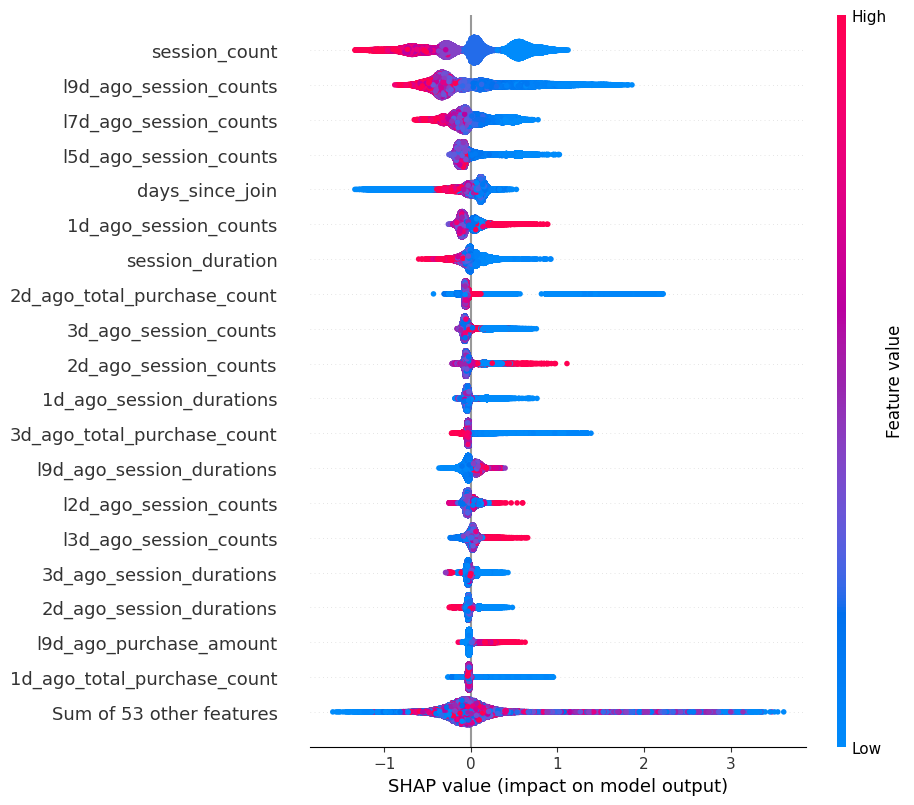

In [308]:
data = classifier.X_test

model = best_lgbm_model['classifier'].best_estimator_
# Create the SHAP explainer using the best model
# compute SHAP values
explainer = shap.Explainer(model, data)
shap_values = explainer(data,check_additivity=False)

shap.plots.beeswarm(shap_values, max_display=20)